In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import cv2
from IPython.display import Image
import os
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/Released_Data/'
sub_class = 'sub_classes_mapping.csv'
super_class = 'super_classes_mapping.csv'
train_data = 'train_data.csv'

# Now you can read or manipulate the file
df_subclass = pd.read_csv(file_path+sub_class)
df_superclass = pd.read_csv(file_path+super_class)
df_train = pd.read_csv(file_path+train_data)

# Example: Print the content
df_subclass.head()

,index,class
0,0,"Scotch terrier, Scottish terrier, Scottie"
1,1,"African chameleon, Chamaeleo chamaeleon"
2,2,standard schnauzer
3,3,terrapin
4,4,"great grey owl, great gray owl, Strix nebulosa"


In [10]:
# # Specify the path to the zip file in your Google Drive
# zip_file_path = '/content/drive/MyDrive/Released_Data/train_shuffle.zip'

# # Specify the destination folder for the extracted files
# extracted_folder_path = '/content/drive/MyDrive/'

# # Unzip the file
# !unzip "$zip_file_path" -d "$extracted_folder_path"

In [4]:
test_path = '/content/drive/MyDrive/test_shuffle/'
train_path = '/content/drive/MyDrive/train_shuffle/'

In [ ]:
def create_train_df(train_path, df_train):
  column_names = ['image', 'image_val', 'sub_classes', 'super_class']
  file_names = []
  images = []
  subclass = []
  superclass = []
  for train in df_train['image']:
    image_path = os.path.join(train_path, train)
    if os.path.exists(image_path):

      # read image
      image = cv2.imread(image_path)

      # Normalize the image (example: scale pixel values to [0, 1])
      normalized_image = image / 255.0

      # Extract the numeric part from the filename
      val_sub = df_train.loc[df_train['image'] == train, 'subclass_index'].values[0]
      val_sup = df_train.loc[df_train['image'] == train, 'superclass_index'].values[0]

      sub = df_subclass.loc[val_sub]['class']
      sup = df_superclass.loc[val_sup]['class']

      subclass.append(sub)
      superclass.append(sup)
      file_names.append(train)
      images.append(normalized_image)

  return pd.DataFrame(list(zip(file_names, images, subclass, superclass)), columns=column_names)



new_df = create_train_df(train_path, df_train)
new_df.head()

KeyboardInterrupt: ignored

In [ ]:
# Function to convert a string representation of a matrix to a NumPy array
def convert_to_array(matrix_string):
    return np.array(matrix_string)

# Apply the conversion function to the entire column
new_df['image_val2'] = new_df['image_val'].apply(convert_to_array)

In [5]:
# Specify the file path within your Google Drive
csv_file_path = '/content/drive/MyDrive/data.csv'

# Write DataFrame to CSV file
new_df.to_csv(csv_file_path, index=False)

NameError: ignored

In [6]:
# Read CSV into DataFrame
df = pd.read_csv(csv_file_path)

In [7]:
df.head(10)

,image,image_val,sub_classes,super_class,image_val2
0,0.jpg,[[[0.65490196 0.61176471 0.64313725]\n [0.494...,"Afghan hound, Afghan",dog,[[[0.65490196 0.61176471 0.64313725]\n [0.494...
1,1.jpg,[[[0.20784314 0.45098039 0.48235294]\n [0.054...,"bald eagle, American eagle, Haliaeetus leucoce...",bird,[[[0.20784314 0.45098039 0.48235294]\n [0.054...
2,2.jpg,[[[0.30980392 0.43137255 0.49019608]\n [0.305...,dowitcher,bird,[[[0.30980392 0.43137255 0.49019608]\n [0.305...
3,3.jpg,[[[0.2627451 0.45490196 0.37647059]\n [0.101...,"Gila monster, Heloderma suspectum",reptile,[[[0.2627451 0.45490196 0.37647059]\n [0.101...
4,4.jpg,[[[0.6 0.53333333 0.57647059]\n [0.627...,"American alligator, Alligator mississipiensis",reptile,[[[0.6 0.53333333 0.57647059]\n [0.627...
5,5.jpg,[[[0.53333333 0.76078431 0.66666667]\n [0.619...,"African chameleon, Chamaeleo chamaeleon",reptile,[[[0.53333333 0.76078431 0.66666667]\n [0.619...
6,6.jpg,[[[0.36078431 0.49411765 0.61176471]\n [0.439...,pelican,bird,[[[0.36078431 0.49411765 0.61176471]\n [0.439...
7,7.jpg,[[[0.47843137 0.4745098 0.51372549]\n [0.505...,"Tibetan terrier, chrysanthemum dog",dog,[[[0.47843137 0.4745098 0.51372549]\n [0.505...
8,8.jpg,[[[0.61960784 0.69803922 0.81960784]\n [0.643...,"bloodhound, sleuthhound",dog,[[[0.61960784 0.69803922 0.81960784]\n [0.643...
9,9.jpg,[[[0.12156863 0.17254902 0.22745098]\n [0. ...,"Afghan hound, Afghan",dog,[[[0.12156863 0.17254902 0.22745098]\n [0. ...


In [8]:
def load_images(image_paths):
    names = df['image'].to_list()
    images = []
    for n in names:
        path = image_paths+n
        img = cv2.imread(path)
        # You might need additional preprocessing here based on your requirements
        images.append(img)
    return np.array(images)

In [9]:
arr = load_images(train_path)

In [10]:
np_path = '/content/drive/MyDrive/np_array.csv'
np.save('np_array.npy', arr)

In [12]:
arr = np.load('np_array.npy')

In [13]:
labels = df['sub_classes'].values

In [14]:
image_data = arr / 255.0

In [59]:
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# # Convert labels to numerical values using LabelEncoder
# label_encoder = LabelEncoder()
# encoded_labels = label_encoder.fit_transform(labels)

# # One-hot encode the numerical labels
# onehot_encoder = OneHotEncoder(sparse=False)
# encoded_labels = encoded_labels.reshape(len(encoded_labels), 1)
from keras.utils import to_categorical
# Use LabelEncoder to convert string labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Convert integer labels to one-hot encoded vectors
onehot_labels = to_categorical(labels)

In [60]:
# Reshape the image to (6200*8, 8, 3)
reshaped_image = image_data.reshape(-1, 8, 8, 3)

# Initialize an empty array to store the upscaled images
upscaled_images = []

# Upscale each 8x8 patch to 32x32 using bilinear interpolation
for patch in reshaped_image:
    upscaled_patch = cv2.resize(patch, (32, 32), interpolation=cv2.INTER_LINEAR)
    upscaled_images.append(upscaled_patch)


In [61]:
# Convert the list of upscaled patches back to a NumPy array
upscaled_image = np.array(upscaled_images)
print(upscaled_image.shape)
# Reshape the final upscaled image to (6200, 32, 32, 3)
upscaled_image = upscaled_image.reshape(6472, 32, 32, 3)
print(onehot_labels.shape)

(6472, 32, 32, 3)
(6472, 89)


In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(89, activation='softmax'))  # Adjust output size based on your classification task

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(upscaled_image, onehot_labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
162/162 [==============================] - 2s 8ms/step - loss: 4.3111 - accuracy: 0.0440 - val_loss: 4.0355 - val_accuracy: 0.0788
Epoch 2/10
162/162 [==============================] - 1s 6ms/step - loss: 3.9664 - accuracy: 0.0894 - val_loss: 3.8716 - val_accuracy: 0.0988
Epoch 3/10
162/162 [==============================] - 1s 5ms/step - loss: 3.7262 - accuracy: 0.1331 - val_loss: 3.6995 - val_accuracy: 0.1506
Epoch 4/10
162/162 [==============================] - 1s 4ms/step - loss: 3.5024 - accuracy: 0.1692 - val_loss: 3.6005 - val_accuracy: 0.1429
Epoch 5/10
162/162 [==============================] - 1s 5ms/step - loss: 3.3159 - accuracy: 0.2104 - val_loss: 3.5555 - val_accuracy: 0.1544
Epoch 6/10
162/162 [==============================] - 1s 5ms/step - loss: 3.1544 - accuracy: 0.2316 - val_loss: 3.5090 - val_accuracy: 0.1514
Epoch 7/10
162/162 [==============================] - 1s 5ms/step - loss: 3.0199 - accuracy: 0.2571 - val_loss: 3.4920 - val_accuracy: 0.1529
Epoch 

In [63]:
import os
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, train_path, df_train, df_subclass, df_superclass, transform=None):
        self.train_path = train_path
        self.df_train = df_train
        self.df_subclass = df_subclass
        self.df_superclass = df_superclass
        self.transform = transform

        self.file_names = df_train['image'].tolist()

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        file_name = self.file_names[index]
        image_path = os.path.join(self.train_path, file_name)

        # Read image
        image = cv2.imread(image_path)
        normalized_image = image / 255.0

        # Extract subclass and superclass labels
        val_sub = self.df_train.loc[self.df_train['image'] == file_name, 'subclass_index'].values[0]
        val_sup = self.df_train.loc[self.df_train['image'] == file_name, 'superclass_index'].values[0]

        sub = self.df_subclass.loc[val_sub]['class']
        sup = self.df_superclass.loc[val_sup]['class']

        # Apply transformations if provided
        # if self.transform:
        # normalized_image = self.transform(normalized_image)

        # # Add this block to transpose the image dimensions

        # Define a transformation
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        # Apply the transformation
        normalized_image = transform(image)
        normalized_image = normalized_image.permute(2, 1, 0)
        normalized_image = np.array(normalized_image)
        upscaled_image = cv2.resize(normalized_image, (32, 32), interpolation=cv2.INTER_LINEAR)
        image = torch.tensor(upscaled_image)

        return {'image': image, 'subclass': sub, 'superclass': sup}

# Example usage
# Assuming train_path, df_train, df_subclass, and df_superclass are defined
# and train_transform is your desired image transformation
train_dataset = CustomDataset(train_path, df_train, df_subclass, df_superclass)

# # Accessing data in the DataLoader
# for i in range(len(train_dataset)):
#     sample = train_dataset[i]
#     image = sample['image']
#     subclass = sample['subclass']
#     superclass = sample['superclass']

#     # Perform your training/validation/testing logic here
#     print(f"Subclass: {subclass}, Superclass: {superclass}, Image Shape: {image.shape}")

torch.Size([32, 32, 3])


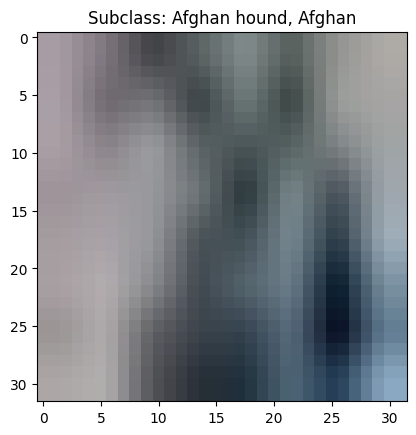

In [64]:
import matplotlib.pyplot as plt
import torch

# Assuming train_dataset is your CustomDataset
# Accessing data for the first sample
sample = train_dataset[0]
image = sample['image']
subclass = sample['subclass']

# Convert the PyTorch tensor to a NumPy array
image = image.permute(1,0,2)
print(image.shape)
image_np = image.numpy()

# Display the image
plt.imshow(image_np)  # Transpose for correct channel order
plt.title(f"Subclass: {subclass}")
plt.show()

In [66]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Assuming train_dataset is your CustomDataset
# Split the dataset into training and validation sets
# upscaled_images,  = train_test_split(train_dataset, test_size=0.2, random_state=42)

# # Define the DataLoader for training and validation sets
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_X,valid_X,train_ground,valid_ground = train_test_split(upscaled_image,
                                                             upscaled_image,
                                                             test_size=0.2,
                                                             random_state=13)

In [ ]:
# Assuming train_loader and val_loader are your DataLoader objects
size_train_loader = len(train_loader)
size_val_loader = len(val_loader)

print(f"Number of batches in training loader: {size_train_loader}")
print(f"Number of batches in validation loader: {size_val_loader}")

batch_size = 32

# Alternatively, if you want to get the number of samples
num_samples_train = size_train_loader * batch_size  # Assuming batch_size is defined
num_samples_val = size_val_loader * batch_size

print(f"Number of samples in training loader: {num_samples_train}")
print(f"Number of samples in validation loader: {num_samples_val}")

Number of batches in training loader: 162
Number of batches in validation loader: 41
Number of samples in training loader: 5184
Number of samples in validation loader: 1312


In [85]:
# Flatten the image data to (6200, 32*32*3)
flattened_image_data = upscaled_image.reshape(upscaled_image.shape[0], -1)

# Perform the train-validation split
train_data, val_data, train_labels, val_labels = train_test_split(
    upscaled_image, onehot_labels, test_size=0.2, random_state=42
)

# Reshape the data back to the original shape
train_data = train_data.reshape(train_data.shape[0], 32, 32, 3)
val_data = val_data.reshape(val_data.shape[0], 32, 32, 3)

In [64]:
input_tensor = tf.keras.Input(shape=(32, 32, 3))

NameError: ignored

In [86]:
import tensorflow as tf
batch_size = 64
epochs = 10
inChannel = 3
x, y = 32, 32
input_img = tf.keras.Input(shape = (x, y, inChannel))
num_classes = 89

In [87]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [88]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [89]:
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_44 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_45 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 16, 16, 32)        0   

In [90]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/10
81/81 [==============================] - 8s 30ms/step - loss: 0.0155 - val_loss: 0.0234
Epoch 2/10
81/81 [==============================] - 2s 22ms/step - loss: 0.0076 - val_loss: 0.0222
Epoch 3/10
81/81 [==============================] - 2s 20ms/step - loss: 0.0067 - val_loss: 0.0180
Epoch 4/10
81/81 [==============================] - 2s 20ms/step - loss: 0.0063 - val_loss: 0.0166
Epoch 5/10
81/81 [==============================] - 2s 21ms/step - loss: 0.0060 - val_loss: 0.0113
Epoch 6/10
81/81 [==============================] - 2s 20ms/step - loss: 0.0058 - val_loss: 0.0070
Epoch 7/10
81/81 [==============================] - 2s 20ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 8/10
81/81 [==============================] - 2s 23ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 9/10
81/81 [==============================] - 2s 25ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 10/10
81/81 [==============================] - 2s 23ms/step - loss: 0.0055 - val_loss: 0.0052


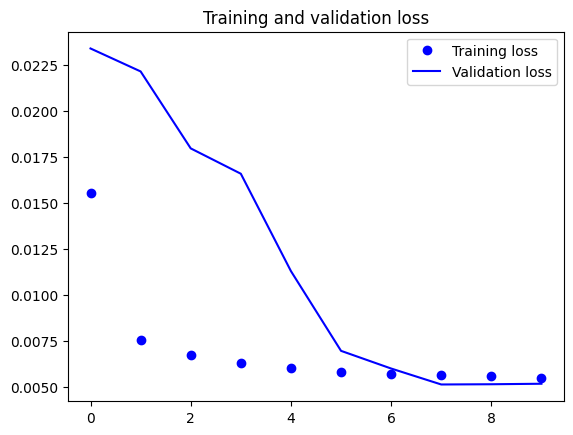

In [91]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(10)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [92]:
autoencoder.save_weights('autoencoder.h5')

In [93]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [94]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [95]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [96]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [97]:
autoencoder.get_weights()[0][1]

array([[[-4.26645651e-02,  3.35904248e-02, -3.93853076e-02,
         -7.18702599e-02, -2.28761341e-02, -1.05232999e-01,
         -1.02194361e-01, -9.75061581e-02, -5.32317162e-02,
         -1.18889011e-01, -7.09315464e-02,  4.93688658e-02,
          2.31342744e-02,  1.16485946e-01,  1.23883680e-01,
          1.07833110e-01, -1.20312691e-01, -7.97835588e-02,
         -1.20980665e-01, -8.78475010e-02, -1.18142374e-01,
          1.33396655e-01, -4.25718538e-02, -1.23843607e-02,
          7.22559616e-02, -4.10377160e-02, -1.00322798e-01,
         -4.60602669e-03,  1.05953500e-01, -3.08621060e-02,
          1.24260157e-01,  1.95793621e-02],
        [ 7.89133236e-02,  4.35788780e-02,  9.75004360e-02,
          1.03105111e-02, -5.30517139e-02, -7.49837607e-02,
          1.19263329e-01,  9.90504846e-02, -8.28088354e-03,
         -8.14313535e-03,  6.10197484e-02,  1.04333311e-01,
          9.71474797e-02,  3.86586189e-02, -2.11124253e-02,
         -8.74956399e-02, -3.08405459e-02, -8.41699317e-

In [98]:
full_model.get_weights()[0][1]

array([[[-4.26645651e-02,  3.35904248e-02, -3.93853076e-02,
         -7.18702599e-02, -2.28761341e-02, -1.05232999e-01,
         -1.02194361e-01, -9.75061581e-02, -5.32317162e-02,
         -1.18889011e-01, -7.09315464e-02,  4.93688658e-02,
          2.31342744e-02,  1.16485946e-01,  1.23883680e-01,
          1.07833110e-01, -1.20312691e-01, -7.97835588e-02,
         -1.20980665e-01, -8.78475010e-02, -1.18142374e-01,
          1.33396655e-01, -4.25718538e-02, -1.23843607e-02,
          7.22559616e-02, -4.10377160e-02, -1.00322798e-01,
         -4.60602669e-03,  1.05953500e-01, -3.08621060e-02,
          1.24260157e-01,  1.95793621e-02],
        [ 7.89133236e-02,  4.35788780e-02,  9.75004360e-02,
          1.03105111e-02, -5.30517139e-02, -7.49837607e-02,
          1.19263329e-01,  9.90504846e-02, -8.28088354e-03,
         -8.14313535e-03,  6.10197484e-02,  1.04333311e-01,
          9.71474797e-02,  3.86586189e-02, -2.11124253e-02,
         -8.74956399e-02, -3.08405459e-02, -8.41699317e-

In [99]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [100]:

full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [101]:
full_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_63 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_58 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_64 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_59 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 16, 16, 32)        0   

In [84]:
classify_train = full_model.fit(train_data, train_labels, batch_size=64,epochs=10,verbose=1,validation_data=(val_data, val_labels))

Epoch 1/10
81/81 [==============================] - 2s 13ms/step - loss: 4.7150 - accuracy: 0.0402 - val_loss: 4.4520 - val_accuracy: 0.0425
Epoch 2/10
81/81 [==============================] - 1s 9ms/step - loss: 4.0965 - accuracy: 0.0923 - val_loss: 4.5446 - val_accuracy: 0.0618
Epoch 3/10
81/81 [==============================] - 1s 8ms/step - loss: 3.6513 - accuracy: 0.1541 - val_loss: 4.4229 - val_accuracy: 0.0795
Epoch 4/10
81/81 [==============================] - 1s 8ms/step - loss: 3.1299 - accuracy: 0.2318 - val_loss: 4.6049 - val_accuracy: 0.0819
Epoch 5/10
81/81 [==============================] - 1s 8ms/step - loss: 2.6372 - accuracy: 0.3193 - val_loss: 4.7727 - val_accuracy: 0.0772
Epoch 6/10
81/81 [==============================] - 1s 8ms/step - loss: 2.1667 - accuracy: 0.4209 - val_loss: 4.9840 - val_accuracy: 0.1035
Epoch 7/10
81/81 [==============================] - 1s 8ms/step - loss: 1.7607 - accuracy: 0.5206 - val_loss: 5.2979 - val_accuracy: 0.1004
Epoch 8/10
81/81 [=

In [102]:
full_model.save_weights('autoencoder_classification.h5')

In [103]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

In [104]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [105]:
classify_train = full_model.fit(train_data, train_labels, batch_size=64,epochs=10,verbose=1,validation_data=(val_data, val_labels))

Epoch 1/10
81/81 [==============================] - 7s 25ms/step - loss: 4.5389 - accuracy: 0.0228 - val_loss: 7.1783 - val_accuracy: 0.0178
Epoch 2/10
81/81 [==============================] - 1s 17ms/step - loss: 4.4415 - accuracy: 0.0230 - val_loss: 5.2444 - val_accuracy: 0.0185
Epoch 3/10
81/81 [==============================] - 1s 17ms/step - loss: 4.3841 - accuracy: 0.0369 - val_loss: 4.6366 - val_accuracy: 0.0286
Epoch 4/10
81/81 [==============================] - 2s 25ms/step - loss: 4.2738 - accuracy: 0.0417 - val_loss: 4.5554 - val_accuracy: 0.0440
Epoch 5/10
81/81 [==============================] - 2s 26ms/step - loss: 4.1972 - accuracy: 0.0541 - val_loss: 4.3834 - val_accuracy: 0.0324
Epoch 6/10
81/81 [==============================] - 1s 16ms/step - loss: 4.1408 - accuracy: 0.0595 - val_loss: 4.2503 - val_accuracy: 0.0494
Epoch 7/10
81/81 [==============================] - 1s 16ms/step - loss: 4.1033 - accuracy: 0.0686 - val_loss: 4.7898 - val_accuracy: 0.0440
Epoch 8/10
81

In [106]:
full_model.save_weights('classification_complete.h5')

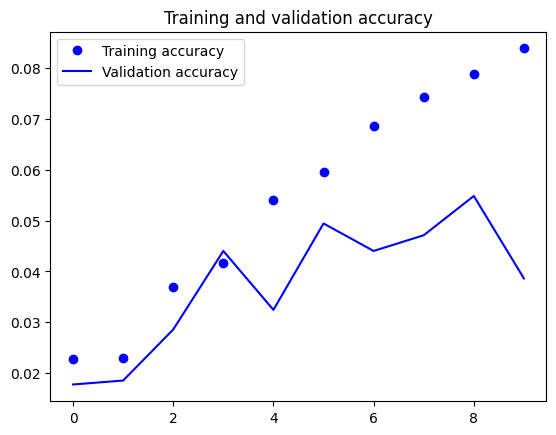

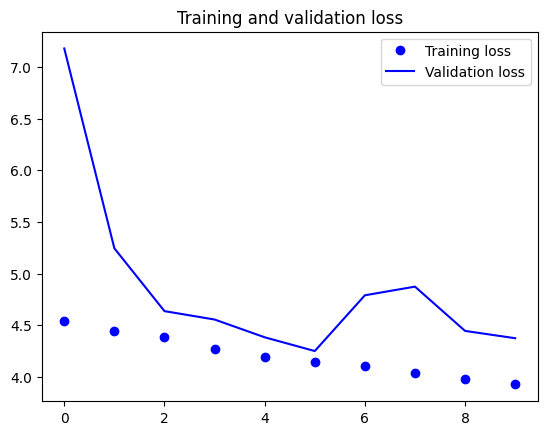

In [107]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [108]:
test_eval = full_model.evaluate(val_data, val_labels, verbose=0)

In [109]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 4.374499320983887
Test accuracy: 0.03861003741621971


In [110]:
predicted_classes = full_model.predict(val_data)

41/41 [==============================] - 0s 3ms/step


In [111]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [112]:
predicted_classes, val_labels

(array([0, 0, 0, ..., 0, 0, 0]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [113]:
correct = np.where(predicted_classes==val_labels)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(val_data[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], val_labels[correct]))
    plt.tight_layout()

Found 0 correct labels


<ipython-input-113-6c5b425a6ec2>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct = np.where(predicted_classes==val_labels)[0]


Found 1 incorrect labels


<ipython-input-114-1c1d092c607d>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  incorrect = np.where(predicted_classes!=val_labels)[0]


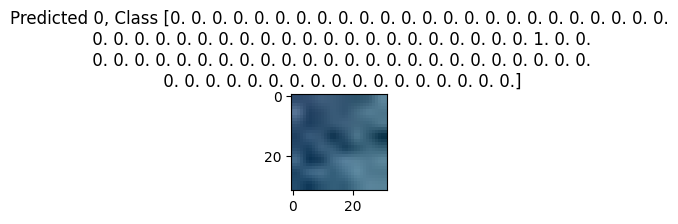

In [114]:
incorrect = np.where(predicted_classes!=val_labels)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:89]):
    plt.subplot(3,3,i+1)
    plt.imshow(val_data[incorrect].reshape(32,32,3), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], val_labels[incorrect]))
    plt.tight_layout()

In [116]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(val_labels, predicted_classes, target_names=target_names))



ValueError: ignored